# Changes to the zonal temperature and SLP gradients in the LongRunMIP
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.io import loadmat
from matplotlib.patches import Polygon
from scipy import signal
from eofs.xarray import Eof
from scipy import stats

Set data locations

In [2]:
loc_slpg = "../Data/SLPG/"
loc_ztg = "../Data/ZTG/"

Model names

In [3]:
modelnames_fig = ['CCSM3 abrupt 2x','CCSM3 abrupt 4x','CCSM3 abrupt 8x', \
    'CESM1.0.4 abrupt 2x','CESM1.0.4 abrupt 4x','CESM1.0.4 abrupt 8x', 'CNRM-CM6.1 abrupt4x', \
    'GFDL-CM3 1pct 2x','GFDL-ESM2M 1pct 2x','GISS-E2-R 1pct 4x', \
    'GISS-E2-R abrupt 4x','HadCM3L abrupt 2x','HadCM3L abrupt 4x', \
    'HadCM3L abrupt 6x','HadCM3L abrupt 8x','IPSL-CM5A-LR abrupt 4x', \
    'MIROC3.2 1pct 2x','MIROC3.2 1pct 4x','MPIESM-1.2 abrupt 2x', \
    'MPIESM-1.2 abrupt 4x','MPIESM-1.2 abrupt 8x'] 

modelnames_file = ['CCSM3_abrupt2x','CCSM3_abrupt4x','CCSM3_abrupt8x', \
    'CESM104_abrupt2x','CESM104_abrupt4x','CESM104_abrupt8x', \
    'CNRMCM61_abrupt4x','GFDLCM3_1pct2x','GFDLESM2M_1pct2x','GISSE2R_1pct4x', \
    'GISSE2R_abrupt4x','HadCM3L_abrupt2x','HadCM3L_abrupt4x', \
    'HadCM3L_abrupt6x','HadCM3L_abrupt8x','IPSLCM5A_abrupt4x', \
    'MIROC32_1pct2x','MIROC32_1pct4x','MPIESM12_abrupt2x', \
    'MPIESM12_abrupt4x','MPIESM12_abrupt8x']

runtype = ['abrupt','abrupt','abrupt','abrupt','abrupt','abrupt','lin','lin','lin', \
            'abrupt','abrupt','abrupt','abrupt','abrupt','abrupt', \
            'lin','lin','abrupt','abrupt','abrupt','abrupt']

colors = [[0,238,0],[0,238,0],[0,238,0], \
          [34,139,34],[34,139,34],[34,139,34],[135,206,255],[16,78,139],[30,144,255], \
          [255,110,180],[255,110,180],[255,0,0],[255,0,0],[255,0,0],[255,0,0], \
          [255,193,37],[122,55,139],[122,55,139],[153,153,153],[153,153,153],[153,153,153]];

colors_double = []
for i in np.arange(0,len(colors),1):
    colors_double.append(colors[i])
    colors_double.append(colors[i])

Function for setting boxplot color

In [4]:
def set_boxplot_col(b,n,c,c_double,lw,median):
    
    # This function sets the colors of a given boxplot b
    # It auto-sets the colors of the boxes, whiskers, caps, and fliers to c[m]
    # and it sets the colors of the medians if median=True
    # n is the number of instances of the boxplot and lw is the desired
    # linewidth
    # c should be a vector of colors
    
    for m in range(0,n*2,1):
        if m < n:
            b["boxes"][m].set(color=c[m],linewidth=lw)
            b["whiskers"][m].set(color=c_double[m],linewidth=lw)
            b["caps"][m].set(color=c_double[m],linewidth=lw)
            #b["fliers"][m].set(markerfacecolor=c[m],markeredgecolor=c[m])
            if median==True:
                b["medians"][m].set(color=c[m],linewidth=lw)
        else:
            b["whiskers"][m].set(color=c_double[m],linewidth=lw)
            b["caps"][m].set(color=c_double[m],linewidth=lw)

#### Analysis

Running mean length

In [5]:
rm_yrs = 100
rm_length = rm_yrs*12

Empty arrays

In [6]:
transient_change_z = np.zeros(len(modelnames_file))
equilibrium_change_z = []
pvals_z = np.zeros(len(modelnames_file))

transient_change_s = np.zeros(len(modelnames_file))
equilibrium_change_s = []
pvals_s = np.zeros(len(modelnames_file))

Loop and add data

In [7]:
for i in np.arange(0,len(modelnames_file),1):
    
    model, exp = modelnames_file[i].split("_")
    print(modelnames_file[i])
    
    if ((model == "MIROC32") | (model == "MPIESM12")):
        slpg_ctrl = xr.DataArray(xr.open_dataset(loc_slpg+"slpg_"+model+"_control.nc",decode_times=False).data_vars["slpg"])
        slpg_forced = xr.DataArray(xr.open_dataset(loc_slpg+"slpg_"+model+"_"+exp+".nc",decode_times=False).data_vars["slpg"])
        
        ztg_ctrl = xr.DataArray(xr.open_dataset(loc_ztg+"ztg_"+model+"_control.nc",decode_times=False).data_vars["ztg"])
        ztg_forced = xr.DataArray(xr.open_dataset(loc_ztg+"ztg_"+model+"_"+exp+".nc",decode_times=False).data_vars["ztg"])
    else:
        slpg_ctrl = xr.DataArray(xr.open_dataset(loc_slpg+"slpg_"+model+"_control.nc").data_vars["slpg"])
        slpg_forced = xr.DataArray(xr.open_dataset(loc_slpg+"slpg_"+model+"_"+exp+".nc").data_vars["slpg"])
        
        ztg_ctrl = xr.DataArray(xr.open_dataset(loc_ztg+"ztg_"+model+"_control.nc").data_vars["ztg"])
        ztg_forced = xr.DataArray(xr.open_dataset(loc_ztg+"ztg_"+model+"_"+exp+".nc").data_vars["ztg"])
    
    # Process SLPG change
    slpg_ctrl_mean = np.mean(slpg_ctrl)
    slpg_forced_runmean1 = pd.Series(slpg_forced).rolling(rm_length,center=False).mean().values
    slpg_control_runmean1 = pd.Series(slpg_ctrl).rolling(rm_length,center=False).mean().values
    
    slpg_forced_runmean = slpg_forced_runmean1[~np.isnan(slpg_forced_runmean1)]
    slpg_control_runmean = slpg_control_runmean1[~np.isnan(slpg_control_runmean1)]
    
    slpg_change = ((slpg_forced_runmean - slpg_ctrl_mean.values)/slpg_ctrl_mean.values)*100
    
    # Process ZTG change
    ztg_ctrl_mean = np.mean(ztg_ctrl)
    ztg_forced_runmean1 = pd.Series(ztg_forced).rolling(rm_length,center=False).mean().values
    ztg_control_runmean1 = pd.Series(ztg_ctrl).rolling(rm_length,center=False).mean().values
    
    ztg_forced_runmean = ztg_forced_runmean1[~np.isnan(ztg_forced_runmean1)]
    ztg_control_runmean = ztg_control_runmean1[~np.isnan(ztg_control_runmean1)]
    
    ztg_change = ((ztg_forced_runmean - ztg_ctrl_mean.values)/ztg_ctrl_mean.values)*100

    
    # Split change into transient and equilibrium
    
    if runtype[i] == "abrupt":
        slpg_change_transient = np.mean(slpg_change[(50*12):(150*12)])
        slpg_change_eq = slpg_change[(150*12):]
        
        ztg_change_transient = np.mean(ztg_change[(50*12):(150*12)])
        ztg_change_eq = ztg_change[(150*12):]
        
        #[T, pvals[i]] = stats.ranksums(x=amp_cdist,y=amp_change[(150*12):])
        
    else:
        slpg_change_transient = np.mean(slpg_change[0:(140*12)])
        slpg_change_eq = slpg_change[(140*12):]

        ztg_change_transient = np.mean(ztg_change[0:(140*12)])
        ztg_change_eq = ztg_change[(140*12):]
        
        #[T, pvals[i]] = stats.ranksums(x=amp_cdist,y=amp_change[(140*12):])
    
    # Add to variables to save
    
    transient_change_s[i] = slpg_change_transient
    equilibrium_change_s.append(slpg_change_eq)
    
    transient_change_z[i] = ztg_change_transient
    equilibrium_change_z.append(ztg_change_eq)

CCSM3_abrupt2x


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


CCSM3_abrupt4x
CCSM3_abrupt8x
CESM104_abrupt2x
CESM104_abrupt4x
CESM104_abrupt8x
CNRMCM61_abrupt4x


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.u

GFDLCM3_1pct2x
GFDLESM2M_1pct2x
GISSE2R_1pct4x
GISSE2R_abrupt4x
HadCM3L_abrupt2x
HadCM3L_abrupt4x
HadCM3L_abrupt6x
HadCM3L_abrupt8x
IPSLCM5A_abrupt4x
MIROC32_1pct2x
MIROC32_1pct4x
MPIESM12_abrupt2x
MPIESM12_abrupt4x
MPIESM12_abrupt8x


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


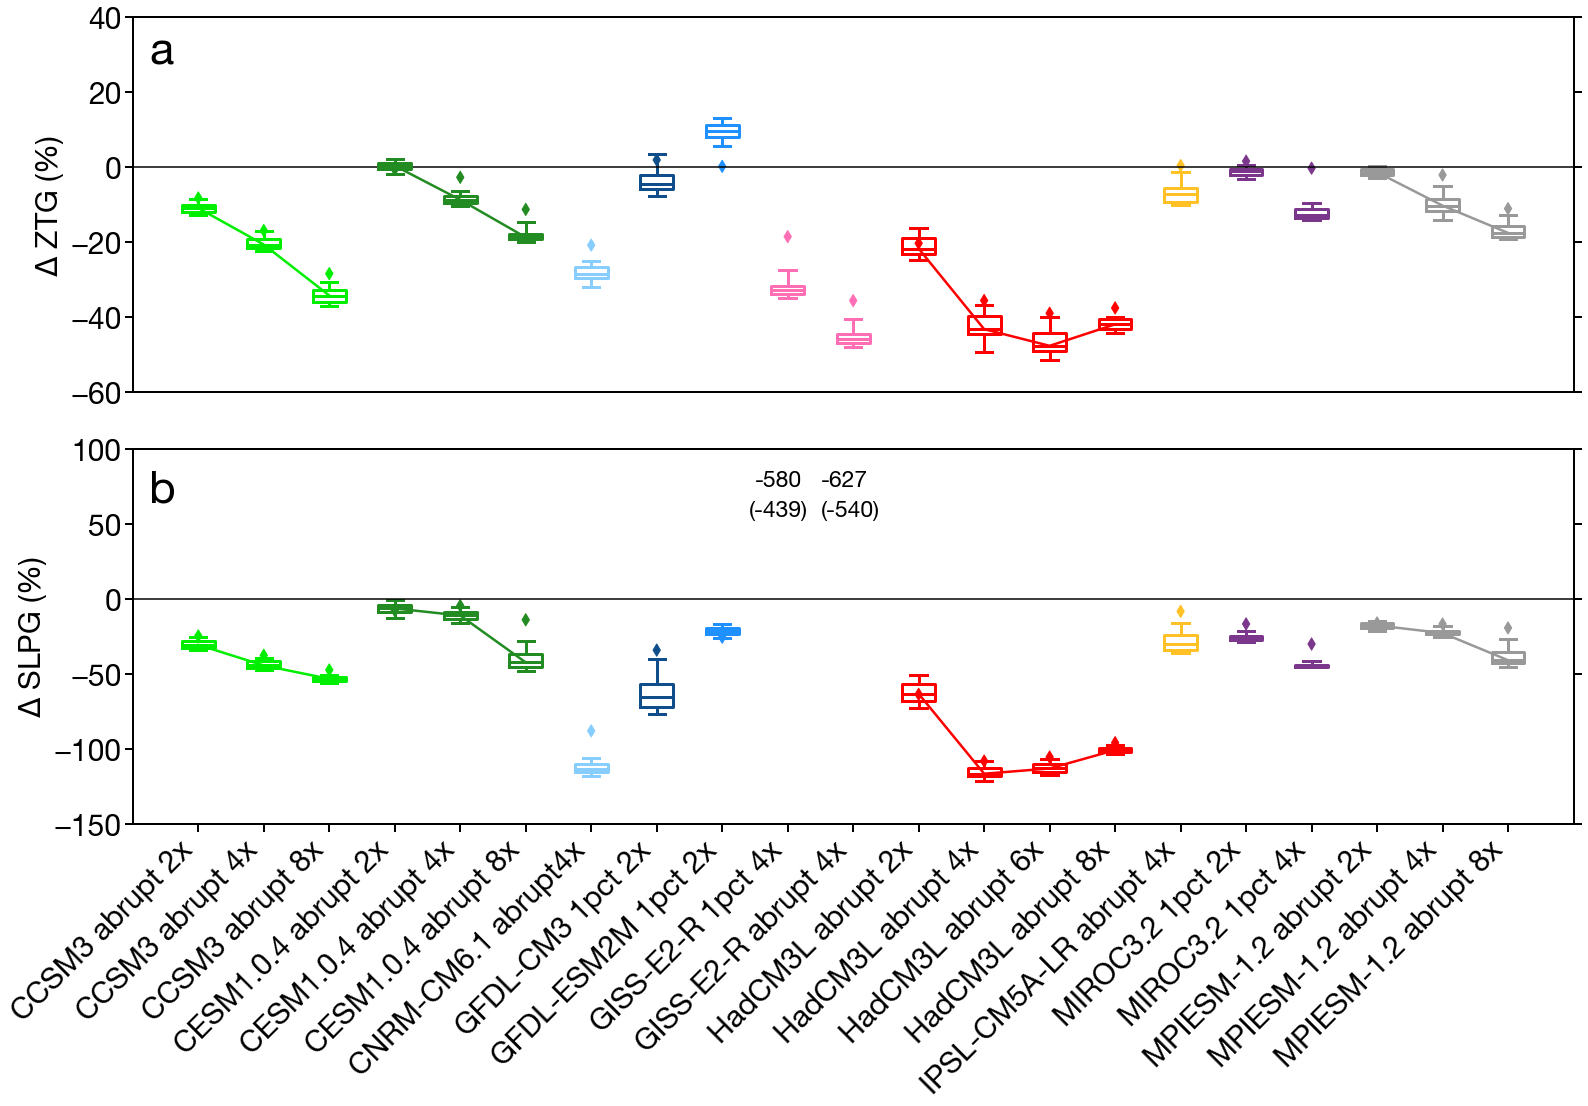

In [9]:
fig = plt.figure(figsize=(23,16))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 30.0
rcParams["axes.linewidth"] = 2
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 2

gs1 = gridspec.GridSpec(2,1)
gs1.update(left=0.1,right=0.97,top=0.95,bottom=0.25,wspace=0.2,hspace=0.15)

for i in np.arange(0,2,1):
    
    ax = plt.subplot(gs1[i,0])
    
    if i == 0:
        eq = equilibrium_change_z
        transient_change = transient_change_z
    else:
        eq = equilibrium_change_s
        transient_change = transient_change_s
        
    
    b1 = plt.boxplot(eq,whis=[5,95],sym="")
    set_boxplot_col(b1,21,np.array(colors)/255.,np.array(colors_double)/255.,3,True)

    plt.scatter(np.arange(1,22,1),transient_change,c=np.array(colors)/255.,s=75,marker="d")
    plt.plot([1,2,3],[np.median(eq[0]),np.median(eq[1]),np.median(eq[2])],linewidth=2.5,color=np.array(colors[0])/255.)
    plt.plot([4,5,6],[np.median(eq[3]),np.median(eq[4]),np.median(eq[5])],linewidth=2.5,color=np.array(colors[3])/255.)
    plt.plot([12,13,14,15],[np.median(eq[11]),np.median(eq[12]),np.median(eq[13]),np.median(eq[14])],linewidth=2.5,color=np.array(colors[12])/255.)
    plt.plot([19,20,21],[np.median(eq[18]),np.median(eq[19]),np.median(eq[20])],linewidth=2.5,color=np.array(colors[18])/255.)
    
    if i == 1: 
        plt.text(9.5,75,"-"+str(int(np.median(eq[9]))),fontsize=23,color="black")
        plt.text(10.5,75,"-"+str(int(np.median(eq[10]))),fontsize=23,color="black")
        plt.text(9.4,55,"(-"+str(int(np.median(transient_change[9])))+")",fontsize=23,color="black")
        plt.text(10.5,55,"(-"+str(int(np.median(transient_change[10])))+")",fontsize=23,color="black")
    
    #for i in np.arange(0,len(ex1)):
        #if pvals[i] >= 0.05:
            #plt.scatter(i+1,-75,color="white",edgecolors=[0.5,0.5,0.5],s=100)

    plt.axhline(y=0,linewidth=1.5,color="k",linestyle="-")

    if i == 1:
        plt.xticks(np.arange(1,22,1),modelnames_fig,rotation=45,horizontalalignment="right")
    else:
        plt.xticks([])
    
    plt.xlim([0,22])
    
    if i == 0:
        plt.ylim([-60,40])
        plt.ylabel("$\Delta$ ZTG (%)")
    else:
        plt.ylim([-150,100])
        plt.ylabel("$\Delta$ SLPG (%)")

    ax2 = ax.twinx()

    plt.scatter(np.arange(1,22,1),transient_change,c="white",s=0,marker="d")
    if i == 0:
        plt.ylim([-60,40])
        plt.ylabel("")
        plt.yticks(ticks=[-60,-40,-20,0,20,40],labels=[])
    else:
        plt.ylim([-150,100])
        plt.ylabel("")
        plt.yticks(ticks=[-150,100,-50,0,50,100],labels=[])


plt.figtext(0.11,0.91,"a",fontsize=45)
plt.figtext(0.11,0.53,"b",fontsize=45)

plt.savefig("../Figures/FigS8_Pacific_Climate.pdf")
plt.show()